In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive

import scipy.stats
from scipy.stats import norm
import statsmodels.api as sm

import hashlib
%matplotlib inline

sns.set(style="dark")
plt.style.use("ggplot")

import pymc3 as pm
import arviz as az

## Loading and Preparing Data

In [2]:
happy = pd.read_csv('World Happiness Report.csv')
life = pd.read_csv('Life Expectancy Data.csv')

In [4]:
# clean column names
happy = happy.rename(columns={"Country Name": "Country"})
life_rename = {col: col.strip() for col in life.columns}
life_rename2 = {key: value.lower() for key, value in life_rename.items()}
life = life.rename(life_rename2, axis=1)

happy_rename = {col: col.strip() for col in happy.columns}
happy_rename2 = {key: value.lower() for key, value in happy_rename.items()}
happy = happy.rename(happy_rename2, axis=1)

# merge happy and life table on country and year
merged = life.merge(happy, how = 'inner', on = ['country', 'year'])

# drop all rows with missing values
merged = merged.dropna()

# drop gdp from life df because we will only use the log gdp from the happy df
merged = merged.drop('gdp', axis=1)

# add binary column indicating a developing or developed country
Status_Indicator = merged.status.map(dict(Developing=0, Developed=1))
merged['status indicator'] = Status_Indicator

# make a dataframe with one row per country
grouped = merged.groupby(['country']).mean()

# list of all columns in merged and in grouped
columns = merged.columns

# EDA

## Visualization 1
This is a helpful visualization for our project because we can already start to see the difference in means between life expectancies in nations classified as developed versus undeveloped. Later on, we are going to see if we can effectively predict whether or not a nation is developed based on variables like life expectancy. We can see that this is probably a good feature to use.

Text(0, 0.5, 'Proportion')

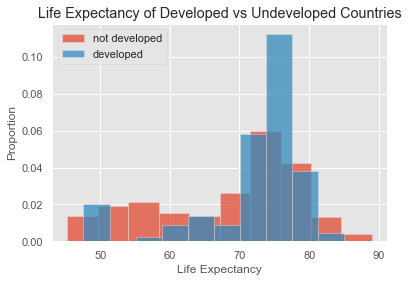

In [5]:
not_developed = np.where(merged['status indicator'] == 0)[0]
developed = np.where(merged['status indicator'] == 1)[0]

plt.hist(life['life expectancy'][not_developed], alpha = .75, density = True, label = 'not developed')
plt.hist(life['life expectancy'][developed], alpha = .75, density = True, label = 'developed')
plt.legend()
plt.title('Life Expectancy of Developed vs Undeveloped Countries')
plt.xlabel('Life Expectancy')
plt.ylabel('Proportion')

## Visualization 2
This visualization shows us the distribution of ladder scores (happiness ranking) according to whether the country is developed or not.

We can see that the Ladder Scores for the for the Developed countries tend to be a bit higher compared to the Developing countries.

This is relevant to our research question because this was a relationship we were going to explore with our hypothesis testing. This visualization shows us that Developed and Developing countries don't come from the same distribution, so we'd like to see if we can explore the correlation between them.

In [6]:
for i in np.arange(len(grouped)): 
    if grouped['status indicator'][i] != 1 and grouped['status indicator'][i] != 0:
        print('True')

This code is a proof that none of our countries change development status in the time period we are looking at so it is okay to group them in our Bayesian model. 

Text(0.5, 1.0, 'Distribution of Years in the dataset')

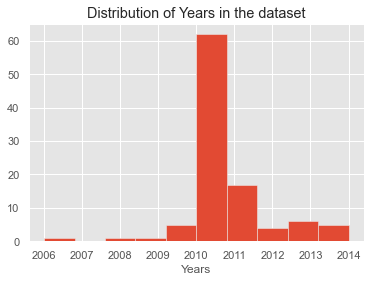

In [7]:
plt.hist(grouped['year'])
plt.xlabel('Years')
plt.title('Distribution of Years in the dataset')

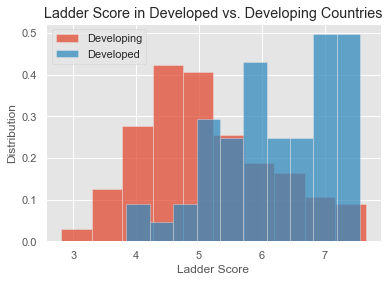

In [8]:
developing = merged.loc[merged['status indicator'] == 0]
developed = merged.loc[merged['status indicator'] == 1]

plt.hist(developing['life ladder'], density = True, alpha = .75)
plt.hist(developed['life ladder'], density = True, alpha = .75)

plt.xlabel('Ladder Score')
plt.ylabel('Distribution')
plt.title('Ladder Score in Developed vs. Developing Countries')
plt.legend(['Developing', 'Developed'])

## Visualization 3
This visualization shows us how similar the life expectancy is from World Health Organization and from the World Happiness Report. The trend is that developed countries, shown in yellow, have a much higher life expectancy than developing countries, shown in purple. It makes sense that the life expectancy’s in both tables are similar. If they were very different and not highly correlated this would have been a read flag for us.

Text(0, 0.5, 'Life Expectancy from World Happiness Report')

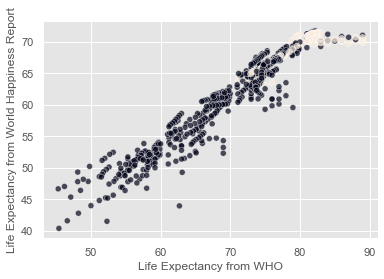

In [9]:
sns.scatterplot(x=merged['life expectancy'], y=merged['healthy life expectancy at birth'], c=merged['status indicator'], alpha=0.7)
plt.xlabel('Life Expectancy from WHO')
plt.ylabel('Life Expectancy from World Happiness Report')

## Visualization 4
These histograms are going to help us identify the prior distributions of our features. These are all for our likelihood terms in our analyses. "Schooling" is normal, "life ladder" is normal, "adult mortality" is beta, "total expenditure" is normal, "alcohol" is exponential, "population" is uniform, "GDP" is exponential, "BMI" multivariate normal", the disease variables are exponential, "thinness" is exponential, and the qualitative happiness features are normal and skewed normal. These serve as a rough estimate of our features, and the titles serve as the labels for each. 

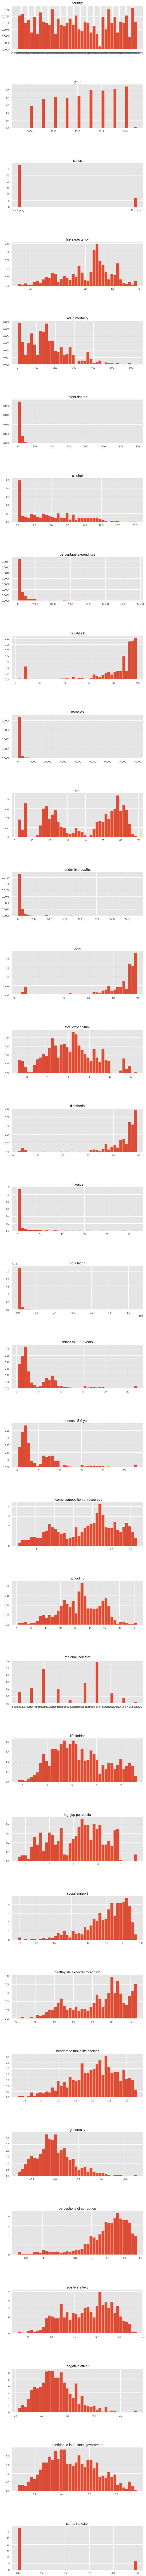

In [10]:
fig, ax = plt.subplots(len(columns), 1, figsize=(10, 200))

for feature in np.arange(len(columns)): 
    plt.subplots_adjust(hspace=0.8)
    ax[feature].hist(merged[columns[feature]], bins = 40, density = True)
    ax[feature].set_title(columns[feature])

## Question 1


Multiple Hypothesis Testing

In [11]:
# columns that we will be looking at for association with life_expectancy

X = ['log gdp per capita',
 'social support',
 'freedom to make life choices',
 'generosity',
 'perceptions of corruption',
 'confidence in national government']

In [14]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

In [15]:
linear_model = fit_OLS_model(merged, 'life expectancy',  X)
pvalues = linear_model.pvalues.values

In [16]:
for i in np.arange(len(X)):
    print(f"The p-value for {X[i]} is {pvalues[i]}")

The p-value for log gdp per capita is 2.3635745290328827e-187
The p-value for social support is 0.014944627438147532
The p-value for freedom to make life choices is 0.23403555418181998
The p-value for generosity is 0.001534054273301533
The p-value for perceptions of corruption is 0.13294584075122742
The p-value for confidence in national government is 0.9392890871553304


## Naive Threshold

In [17]:
def naive_alpha_threshold(p_values, alpha):
    """
    Returns decisions on p-values using naive (uncorrected) thresholding.
    
    Inputs:
        p_values: array of p-values
        alpha: threshold (significance level)
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant at level `alpha`, and 0 otherwize
    """
    
    decisions = np.array(alpha >= p_values)
    return decisions

In [18]:
decisions = naive_alpha_threshold(pvalues, 0.05)
decisions

array([ True,  True, False,  True, False, False])

In [19]:
for i in np.arange(len(X)):
    print(f"For the feature {X[i]} we favored the alternative hypothesis: {decisions[i]}")
    print(f"Meaning, it is {decisions[i]} that there is an association between {X[i]} and life expectancy.")
    print()

For the feature log gdp per capita we favored the alternative hypothesis: True
Meaning, it is True that there is an association between log gdp per capita and life expectancy.

For the feature social support we favored the alternative hypothesis: True
Meaning, it is True that there is an association between social support and life expectancy.

For the feature freedom to make life choices we favored the alternative hypothesis: False
Meaning, it is False that there is an association between freedom to make life choices and life expectancy.

For the feature generosity we favored the alternative hypothesis: True
Meaning, it is True that there is an association between generosity and life expectancy.

For the feature perceptions of corruption we favored the alternative hypothesis: False
Meaning, it is False that there is an association between perceptions of corruption and life expectancy.

For the feature confidence in national government we favored the alternative hypothesis: False
Meanin

Text(0.5, 1.0, 'P-values and decisions using p-value threshold 0.05, with ground truth labels')

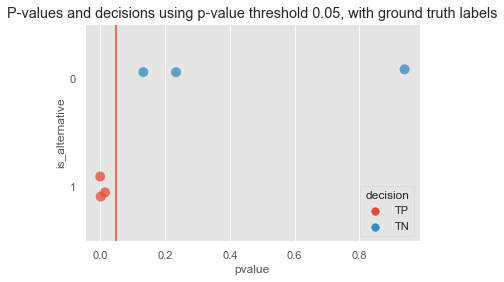

In [20]:
p_and_decisions = pd.DataFrame(data={'pvalue': pvalues, 'is_alternative': decisions.astype(int)})
threshold = 0.05
p_and_decisions['decision'] = 'TP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'TN'
p_and_decisions.loc[(p_and_decisions['pvalue'] < threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'FP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (p_and_decisions['is_alternative']), 'decision'] = 'FN'
sns.stripplot(
    data=p_and_decisions, x='pvalue', y='is_alternative', 
    alpha = 0.75, order = [0, 1], hue='decision', orient = "h",
    s=10
)
plt.axvline(threshold)
plt.title('P-values and decisions using p-value threshold {}, with ground truth labels'.format(threshold))

## Benjamini Yekutieli Correction

In [29]:
def benjamini_yekutieli(p_values, alpha):
    """
    Returns decisions on p-values using Benjamini-Hochberg.
    
    Inputs:
        p_values: array of p-values
        alpha: desired FDR (FDR = E[# false positives / # positives])
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    n = len(p_values)
    c = np.sum([1/i for i in np.arange(1, n+1)])
    assorted_p = sorted(p_values)
    line = sorted([k*(alpha)/(n * c) for k in range(1, len(assorted_p) + 1)])
    
    chosen_p = 0 
    for i in range(len(assorted_p)):
        if line[i] > assorted_p[i]:
            chosen_p = i
    
    decisions = np.array(assorted_p[chosen_p] >= p_values)
    return decisions

In [30]:
decision_by = benjamini_yekutieli(pvalues, 0.05)
decision_by

array([ True, False, False,  True, False, False])

In [31]:
for i in np.arange(len(X)):
    print(f"For the feature {X[i]} we favored the alternative hypothesis: {decision_by[i]}")
    print(f"Meaning, it is {decision_by[i]} that there is an association between {X[i]} and life expectancy.")
    print()

For the feature log gdp per capita we favored the alternative hypothesis: True
Meaning, it is True that there is an association between log gdp per capita and life expectancy.

For the feature social support we favored the alternative hypothesis: False
Meaning, it is False that there is an association between social support and life expectancy.

For the feature freedom to make life choices we favored the alternative hypothesis: False
Meaning, it is False that there is an association between freedom to make life choices and life expectancy.

For the feature generosity we favored the alternative hypothesis: True
Meaning, it is True that there is an association between generosity and life expectancy.

For the feature perceptions of corruption we favored the alternative hypothesis: False
Meaning, it is False that there is an association between perceptions of corruption and life expectancy.

For the feature confidence in national government we favored the alternative hypothesis: False
Mean

Text(0.5, 1.0, 'P-values and decisions using p-value threshold 0.05, with ground truth labels')

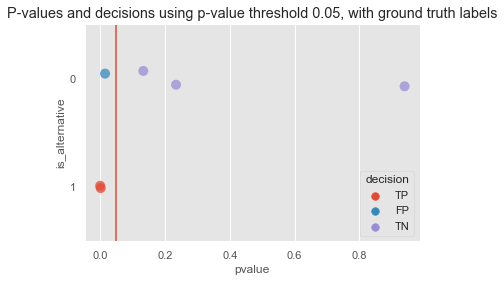

In [32]:
p_and_decisions = pd.DataFrame(data={'pvalue': pvalues, 'is_alternative': decision_by.astype(int)})
threshold = 0.05
p_and_decisions['decision'] = 'TP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'TN'
p_and_decisions.loc[(p_and_decisions['pvalue'] < threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'FP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (p_and_decisions['is_alternative']), 'decision'] = 'FN'
sns.stripplot(
    data=p_and_decisions, x='pvalue', y='is_alternative', 
    alpha = 0.75, order = [0, 1], hue='decision', orient = "h", s=10
)
plt.axvline(threshold)
plt.title('P-values and decisions using p-value threshold {}, with ground truth labels'.format(threshold))

## Bonferroni Correction

In [33]:
def bonferroni(p_values, alpha_total):
    """
    Returns decisions on p-values using the Bonferroni correction.
    
    Inputs:
        p_values: array of p-values
        alpha_total: desired family-wise error rate (FWER = P(at least one false discovery))
    
    Returns:
        decisions: binary array of same length as p-values, where `decisions[i]` is 1
        if `p_values[i]` is deemed significant, and 0 otherwise
    """
    decisions = [(alpha_total)/len(p_values) >= p for p in p_values]
    return np.array(decisions)

In [34]:
decision_b = bonferroni(pvalues, 0.05)
decision_b

array([ True, False, False,  True, False, False])

In [35]:
for i in np.arange(len(X)):
    print(f"For the feature {X[i]} we favored the alternative hypothesis: {decision_b[i]}")
    print(f"Meaning, it is {decision_b[i]} that there is an association between {X[i]} and life expectancy.")
    print()

For the feature log gdp per capita we favored the alternative hypothesis: True
Meaning, it is True that there is an association between log gdp per capita and life expectancy.

For the feature social support we favored the alternative hypothesis: False
Meaning, it is False that there is an association between social support and life expectancy.

For the feature freedom to make life choices we favored the alternative hypothesis: False
Meaning, it is False that there is an association between freedom to make life choices and life expectancy.

For the feature generosity we favored the alternative hypothesis: True
Meaning, it is True that there is an association between generosity and life expectancy.

For the feature perceptions of corruption we favored the alternative hypothesis: False
Meaning, it is False that there is an association between perceptions of corruption and life expectancy.

For the feature confidence in national government we favored the alternative hypothesis: False
Mean

Text(0.5, 1.0, 'P-values and decisions using p-value threshold 0.05, with ground truth labels')

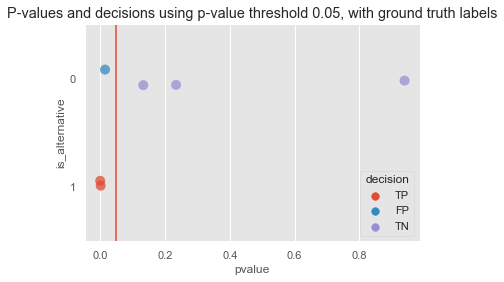

In [36]:
p_and_decisions = pd.DataFrame(data={'pvalue': pvalues, 'is_alternative': decision_by.astype(int)})
threshold = 0.05
p_and_decisions['decision'] = 'TP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'TN'
p_and_decisions.loc[(p_and_decisions['pvalue'] < threshold) & (~p_and_decisions['is_alternative']), 'decision'] = 'FP'
p_and_decisions.loc[(p_and_decisions['pvalue'] > threshold) & (p_and_decisions['is_alternative']), 'decision'] = 'FN'
sns.stripplot(
    data=p_and_decisions, x='pvalue', y='is_alternative', 
    alpha = 0.75, order = [0, 1], hue='decision', orient = "h", s=10
)
plt.axvline(threshold)
plt.title('P-values and decisions using p-value threshold {}, with ground truth labels'.format(threshold))

### Calculating Power for the Hypothesis: Freedom to make life choices has no effect on life expectancy.

In [37]:
effect_size = np.mean(merged['freedom to make life choices'])-np.mean(merged['life expectancy'])/np.std(merged['freedom to make life choices'])
effect_size

-495.03233876717525

In [38]:
from statsmodels.stats.power import TTestPower

power = TTestPower()
test = power.power(nobs=len(merged), effect_size=effect_size, alpha = .05)
print('Power: {:.5f}'.format(test))

Power: 1.00000


## Question 2 


Bayesian Hierarchical Modeling

### Parameters for the the Prior and Likelihood distributions

In [39]:
pi = sum(grouped['status indicator']) / len(grouped)
sigma = 0.4    
mu_gdp = 9.075154
sigma_gdp = 1.165183
mu_a_mort = 1.583724e+02
mu_expectancy = 7.009000e+01
mu_infant = 3.773170e+01
mu_expend = 9.270263e+02
bmi_lower = 0
bmi_upper = 70
mu_pop = 1.726651e+07
mu_icr = 0.660583
sigma_icr = 0.165132
mu_sch = 12.501560
sigma_sch = 2.936952
mu_ss = 0.788118
sigma_ss = 0.128020
mu_choice = 0.705726
sigma_choice = 0.135607
mu_gen = 0.002737
sigma_gen = 0.163503
mu_corr = 0.782561
sigma_corr = 0.141009
mu_conf = 0.486301
sigma_conf = 0.174530

In [40]:
observed = grouped[['life expectancy', 'adult mortality', 'log gdp per capita', 
                  'infant deaths', 'percentage expenditure', 'bmi', 'population',
                 'income composition of resources', 'schooling', 'life ladder', 'social support',
                 'freedom to make life choices', 'generosity', 'perceptions of corruption',
                 'confidence in national government']]

## Model with Happiness Features

In [47]:
with pm.Model() as develop_prediction:
    
    # is country i developed or not?
    y = pm.Bernoulli('status', p = pi)
    
    #features we're observing
    poi_2 = pm.Uniform('life expectancy', lower=48, upper=85, shape = 2)    # life expectancy from who
    nor = pm.Normal('gdp', mu = mu_gdp, sigma = sigma_gdp, shape = 2)    # gdp per capita
    poi = pm.Exponential('adult mortality', lam = mu_a_mort, shape = 2)    # adult mortality
    poi_3 = pm.Poisson('infant deaths', mu = mu_infant, shape = 2)    # infant deaths
    exp = pm.Exponential('percentage expenditure', lam = mu_expend, shape = 2)    # percentage expenditure
    uni = pm.Uniform('bmi', lower = bmi_lower, upper = bmi_upper, shape = 2)    # bmi
    poi_4 = pm.Poisson('population', mu = mu_pop, shape = 2)    # population
    bet = pm.Beta('income composition of resources', mu = mu_icr, sigma = sigma_icr, shape = 2)    # income comp of resources
    gam = pm.Gamma('schooling', mu = mu_sch, sigma = sigma_sch, shape = 2)    # schooling
    uni_2 = pm.Uniform('life ladder', lower = 0, upper = 10, shape = 2)    # life ladder
    bet_2 = pm.Beta('social support', mu = mu_ss, sigma = sigma_ss, shape = 2)    # social support
    bet_3 = pm.Beta('freedom to make life choices', mu = mu_choice, sigma = sigma_choice, shape = 2)    # freedom to make life choices
    nor_2 = pm.Normal('generosity', mu = mu_gen, sigma = sigma_gen, shape = 2)    # generosity
    bet_4 = pm.Beta('perceptions of corruption', mu = mu_corr, sigma = sigma_corr, shape = 2)    # perceptions of corruption
    bet_5 = pm.Beta('confidence in national government', mu = mu_conf, sigma = sigma_conf, shape = 2)    # confidence in national government
    
    # fancy indexing
    expect= poi_2.random()[y.random()]
    gdp_mean = nor.random()[y.random()]
    mort_mean = poi.random()[y.random()]
    infant = poi_3.random()[y.random()]
    expend = exp.random()[y.random()]
    bmi = uni.random()[y.random()]
    pop = poi_4.random()[y.random()]
    icr = bet.random()[y.random()]
    sch = gam.random()[y.random()]
    ladd = uni_2.random()[y.random()]
    soc = bet_2.random()[y.random()]
    free = bet_3.random()[y.random()]
    gen = nor_2.random()[y.random()]
    corr = bet_4.random()[y.random()]
    conf = bet_5.random()[y.random()]
    
    
    # putting the model together

    x = pm.Normal('x', mu = ((1/15)*expect + (1/15)*gdp_mean+ (1/15)*mort_mean + 
                            (1/15)*infant + (1/15)*expend + (1/15)*bmi + 
                            (1/15)*pop + (1/15)*icr + (1/15)*sch + (1/15)*ladd + 
                             (1/15)*soc + (1/15)*free + (1/15)*gen + (1/15)*corr + (1/15)*conf),
                  sigma = sigma, 
                 observed=observed) 
    
    trace = pm.sample(2000, chains = 2, tune=3000,  return_inferencedata=True, init='adapt_diag')
    
    #posterior predictive check
    ppc = pm.sample_posterior_predictive(trace, model=develop_prediction, samples=500) #samples=500, model=develop_prediction, size=100
#     ppc['x'] = ppc['x'] + 0.0
#     ppc_status = az.from_pymc3(trace=trace, posterior_predictive=ppc)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [status]
>NUTS: [confidence in national government, perceptions of corruption, generosity, freedom to make life choices, social support, life ladder, schooling, income composition of resources, bmi, percentage expenditure, adult mortality, gdp, life expectancy]
>CompoundStep
>>Metropolis: [population]
>>Metropolis: [infant deaths]


/Users/cassandracalciano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 22 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.884, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/Users/cassandracalciano/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains m

### Posterior Predictive for the Model with Happiness Features

In [49]:
# with develop_prediction:
#     # posterior predictive check
#     ppc = pm.sample_posterior_predictive(trace, samples=500) #samples=500, model=develop_prediction, size=100
#     ppc['x'] = ppc['x'] + 0.0
#     ppc_status = az.from_pymc3(trace=trace, posterior_predictive=ppc)

In [76]:
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve)

In [59]:
chain_count =  trace.values #get_values(az.summary(trace).index[1:]).shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=predict_development)
#data_spp = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)

NameError: name 'predict_development' is not defined

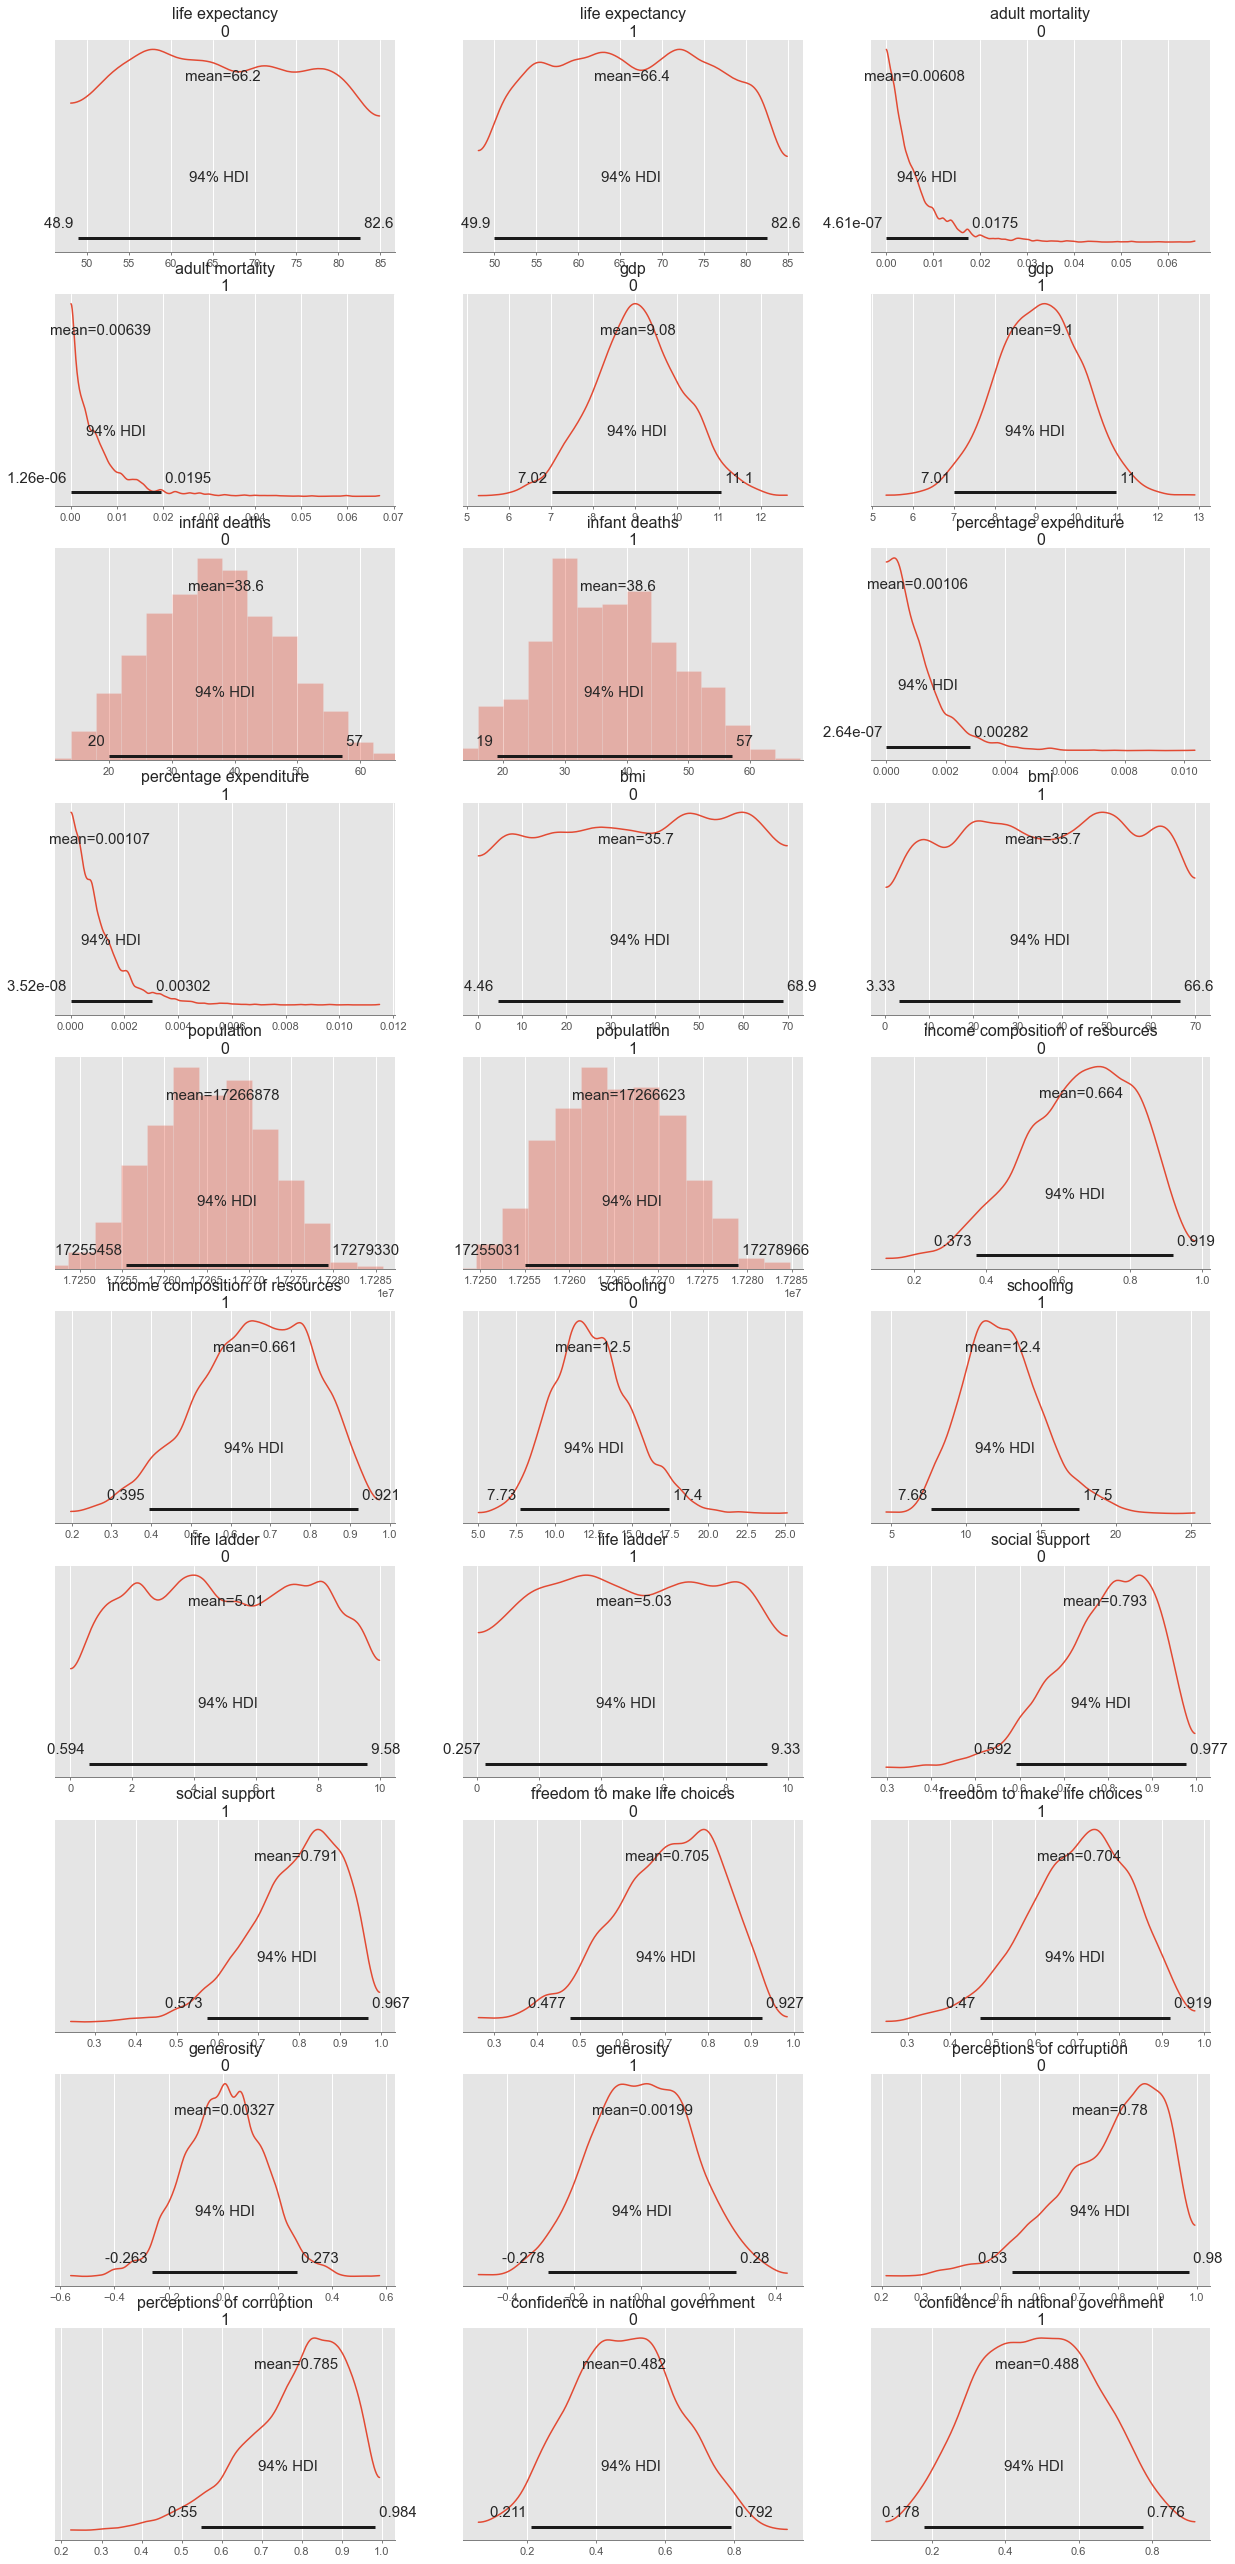

In [100]:
az.plot_posterior(trace, to_graph, round_to = 3)
plt.show()

In [ ]:
trace.

In [87]:
#y_score = np.mean(ppc['x'], axis=0)
y_score = np.mean(ppc['x'], axis=0)
pred_scores = dict(y_true=grouped['status indicator'], y_score=y_score)
roc_auc_score(**pred_scores)

ValueError: multi_class must be in ('ovo', 'ovr')

In [61]:
observed.columns

Index(['life expectancy', 'adult mortality', 'log gdp per capita',
       'infant deaths', 'percentage expenditure', 'bmi', 'population',
       'income composition of resources', 'schooling', 'life ladder',
       'social support', 'freedom to make life choices', 'generosity',
       'perceptions of corruption', 'confidence in national government'],
      dtype='object')

In [97]:
to_graph = ['life expectancy', 'adult mortality', 'gdp',
       'infant deaths', 'percentage expenditure', 'bmi', 'population',
       'income composition of resources', 'schooling', 'life ladder',
       'social support', 'freedom to make life choices', 'generosity',
       'perceptions of corruption', 'confidence in national government']



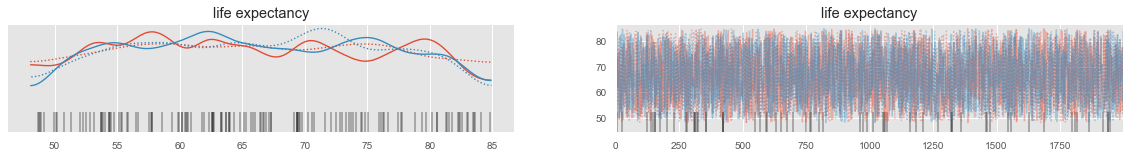

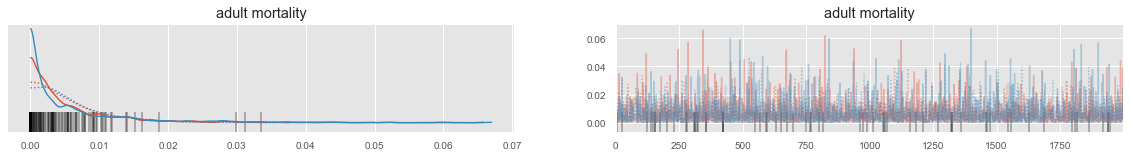

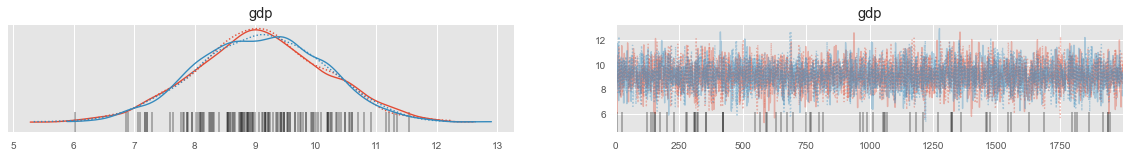

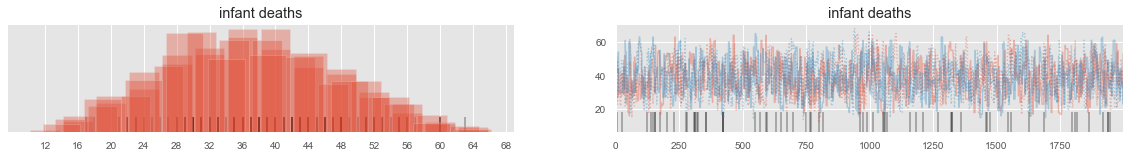

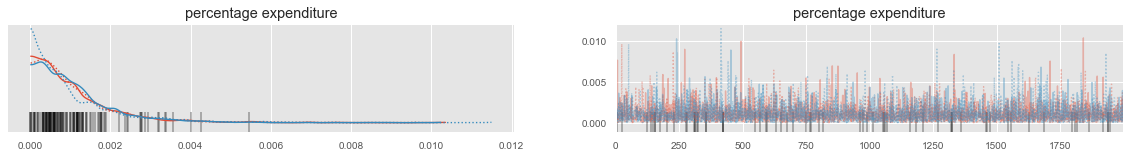

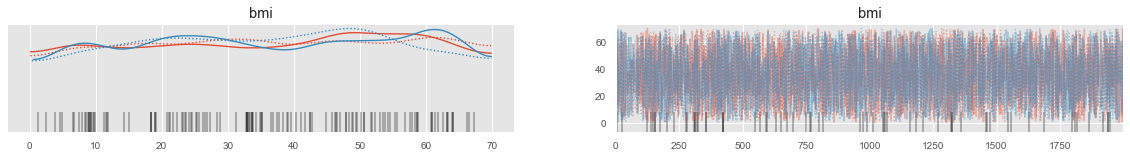

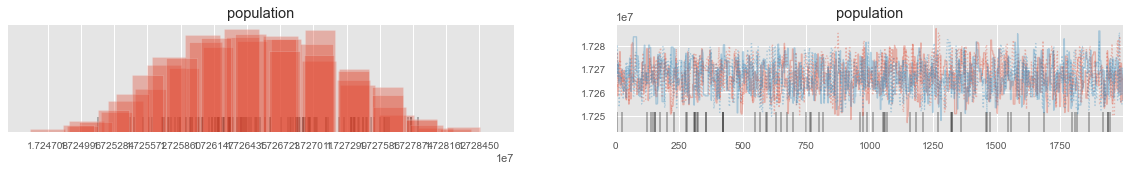

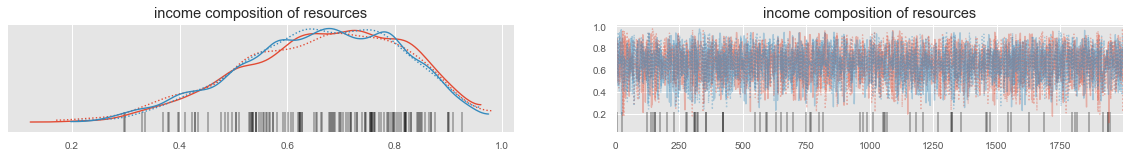

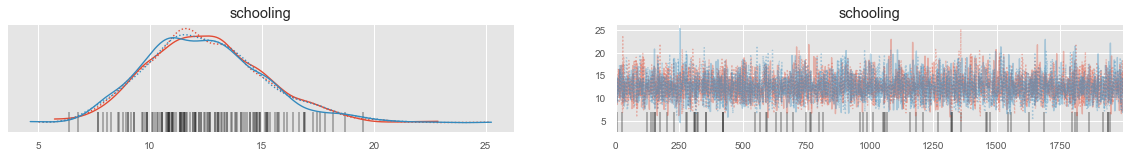

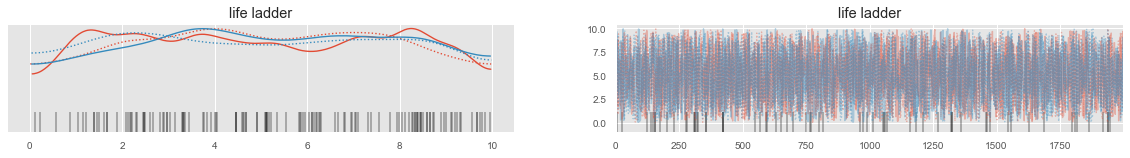

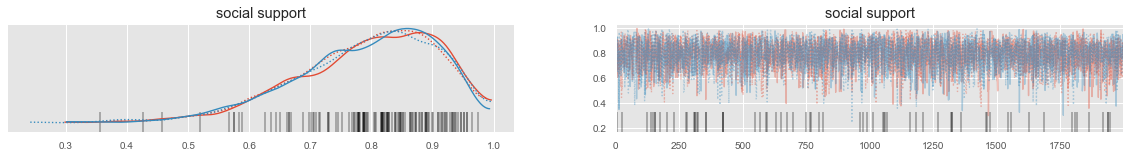

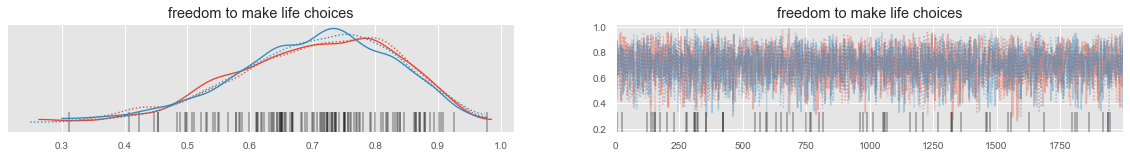

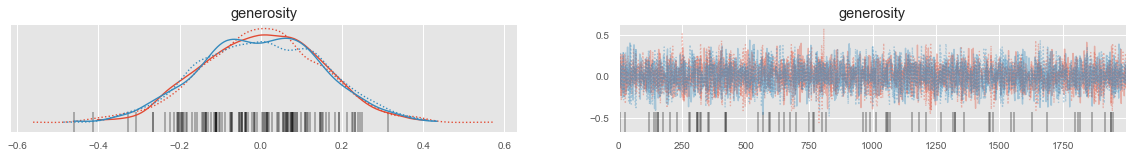

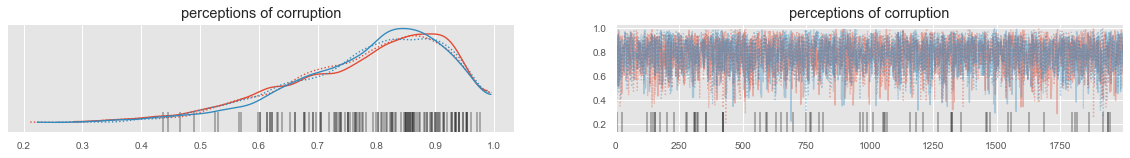

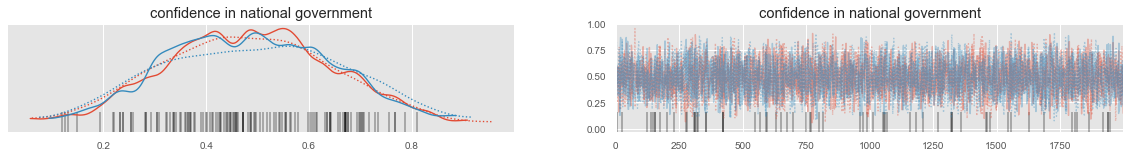

In [98]:
for feature in to_graph:
    trace_fig = az.plot_trace(trace,
    var_names=[feature],
     figsize=(20, 2));

IndentationError: unexpected indent (2681402254.py, line 2)

In [ ]:
posterior_params = pm.plot_posterior(data_spp,
                                     point_estimate='mean',
                                     credible_interval=0.99,
                                     textsize=20,
                                     round_to=4);

In [73]:
crit_l = np.percentile(ppc["x"],q=2.5,axis=0)  # grab lower 2.5% quantiles
crit_u = np.percentile(ppc["x"],q=97.5,axis=0)  # grab Upper 92.5% quantiles
mean_spp = np.mean(ppc["x"], axis=0) # Median

In [ ]:
# az.plot_ppc(ppc_status)
# plt.xlabel('X')
# plt.title('Posterior Predictive')
# plt.show()

In [53]:
az.summary(trace).index[1:]

Index(['gdp[0]', 'gdp[1]', 'infant deaths[0]', 'infant deaths[1]',
       'population[0]', 'population[1]', 'generosity[0]', 'generosity[1]',
       'life expectancy[0]', 'life expectancy[1]', 'adult mortality[0]',
       'adult mortality[1]', 'percentage expenditure[0]',
       'percentage expenditure[1]', 'bmi[0]', 'bmi[1]',
       'income composition of resources[0]',
       'income composition of resources[1]', 'schooling[0]', 'schooling[1]',
       'life ladder[0]', 'life ladder[1]', 'social support[0]',
       'social support[1]', 'freedom to make life choices[0]',
       'freedom to make life choices[1]', 'perceptions of corruption[0]',
       'perceptions of corruption[1]', 'confidence in national government[0]',
       'confidence in national government[1]'],
      dtype='object')

In [30]:
trace.posterior

<xarray.Dataset>
Dimensions:                                  (chain: 2, draw: 2000,
                                              gdp_dim_0: 2,
                                              infant deaths_dim_0: 2,
                                              population_dim_0: 2,
                                              generosity_dim_0: 2,
                                              life expectancy_dim_0: 2,
                                              ...
                                              schooling_dim_0: 2,
                                              life ladder_dim_0: 2,
                                              social support_dim_0: 2,
                                              freedom to make life choices_dim_0: 2,
                                              perceptions of corruption_dim_0: 2,
                                              confidence in national government_dim_0: 2)
Coordinates: (12/17)
  * chain                                    (chain) int64 0 1
  * draw                                     (draw) int64 0 1 2 ... 1998 1999
  * gdp_dim_0                                (gdp_dim_0) int64 0 1
  * infant deaths_dim_0                      (infant deaths_dim_0) int64 0 1
  * population_dim_0                         (population_dim_0) int64 0 1
  * generosity_dim_0                         (generosity_dim_0) int64 0 1
    ...                                       ...
  * schooling_dim_0                          (schooling_dim_0) int64 0 1
  * life ladder_dim_0                        (life ladder_dim_0) int64 0 1
  * social support_dim_0                     (social support_dim_0) int64 0 1
  * freedom to make life choices_dim_0       (freedom to make life choices_dim_0) int64 ...
  * perceptions of corruption_dim_0          (perceptions of corruption_dim_0) int64 ...
  * confidence in national government_dim_0  (confidence in national government_dim_0) int64 ...
Data variables: (12/16)
    status                                   (chain, draw) int64 0 0 1 ... 1 0 0
    gdp                                      (chain, draw, gdp_dim_0) float64 ...
    infant deaths                            (chain, draw, infant deaths_dim_0) int64 ...
    population                               (chain, draw, population_dim_0) int64 ...
    generosity                               (chain, draw, generosity_dim_0) float64 ...
    life expectancy                          (chain, draw, life expectancy_dim_0) float64 ...
    ...                                       ...
    schooling                                (chain, draw, schooling_dim_0) float64 ...
    life ladder                              (chain, draw, life ladder_dim_0) float64 ...
    social support                           (chain, draw, social support_dim_0) float64 ...
    freedom to make life choices             (chain, draw, freedom to make life choices_dim_0) float64 ...
    perceptions of corruption                (chain, draw, perceptions of corruption_dim_0) float64 ...
    confidence in national government        (chain, draw, confidence in national government_dim_0) float64 ...
Attributes:
    created_at:                 2023-05-08T18:22:01.671085
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              21.60031294822693
    tuning_steps:               3000

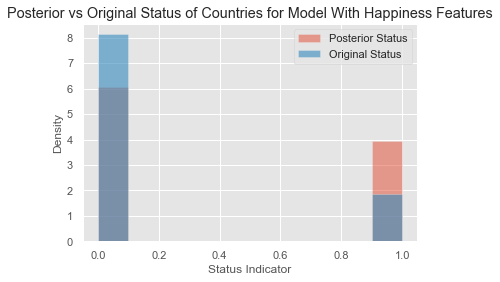

In [44]:
plt.hist(trace.posterior['status'].values.flatten(), density=True, alpha=0.5, label='Posterior Status') 
plt.hist(x=grouped['status indicator'], density=True, alpha=0.6, label='Original Status')

plt.xlabel('Status Indicator')
plt.ylabel('Density')
plt.title('Posterior vs Original Status of Countries for Model With Happiness Features')
plt.legend(loc='upper right')

In [45]:
def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5)

In [47]:
sample_post_pred = ppc['x']
sample_post_pred.mean()

1150446.692448839

In [48]:
plot_hist(sample_post_pred, label='posterior pred')

ValueError: Must pass 2-d input. shape=(4000, 102, 15)

## Model Without Happiness Features

In [52]:
with pm.Model() as develop_prediction_without_happy:
    
    # is country i developed or not?
    y = pm.Bernoulli('status', p = pi)
    
    #features we're observing
    poi_2 = pm.Uniform('life expectancy', lower=48, upper=85, shape = 2)    # life expectancy from who
    nor = pm.Normal('gdp', mu = mu_gdp, sigma = sigma_gdp, shape = 2)    # gdp per capita
    poi = pm.Exponential('adult mortality', lam = mu_a_mort, shape = 2)    # adult mortality
    poi_3 = pm.Poisson('infant deaths', mu = mu_infant, shape = 2)    # infant deaths
    exp = pm.Exponential('percentage expenditure', lam = mu_expend, shape = 2)    # percentage expenditure
    uni = pm.Uniform('bmi', lower = bmi_lower, upper = bmi_upper, shape = 2)    # bmi
    poi_4 = pm.Poisson('population', mu = mu_pop, shape = 2)    # population
    bet = pm.Beta('income composition of resources', mu = mu_icr, sigma = sigma_icr, shape = 2)    # income comp of resources
    gam = pm.Gamma('schooling', mu = mu_sch, sigma = sigma_sch, shape = 2)    # schooling
    
    # fancy indexing
    expect= poi_2.random()[y.random()]
    gdp_mean = nor.random()[y.random()]
    mort_mean = poi.random()[y.random()]
    infant = poi_3.random()[y.random()]
    expend = exp.random()[y.random()]
    bmi = uni.random()[y.random()]
    pop = poi_4.random()[y.random()]
    icr = bet.random()[y.random()]
    sch = gam.random()[y.random()]
    
    
    # putting the model together
    x = pm.Normal('x', mu = ((1/9)*expect + (1/9)*gdp_mean+ (1/9)*mort_mean + 
                            (1/9)*infant + (1/9)*expend + (1/9)*bmi + 
                            (1/9)*pop + (1/9)*icr + (1/9)*sch),
                  sigma = sigma, 
                  observed = observed)
    
    trace_without = pm.sample(2000, chains = 2, tune=3000,  return_inferencedata=True, init='adapt_diag')

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [status]
>NUTS: [schooling, income composition of resources, bmi, percentage expenditure, adult mortality, gdp, life expectancy]
>CompoundStep
>>Metropolis: [population]
>>Metropolis: [infant deaths]


/Users/cassandracalciano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 20 seconds.
There were 667 divergences after tuning. Increase `target_accept` or reparameterize.
There were 679 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


### Posterior Predictive for Model Without Happiness Features

In [54]:
with develop_prediction:
    # posterior predictive check
    ppc = pm.sample_posterior_predictive(trace_without, samples=1000, size=100) #samples=500, model=develop_prediction, size=100
    ppc['x'] = ppc['x'] + 0.0
    ppc_status = az.from_pymc3(trace=trace, posterior_predictive=ppc, log_likelihood=False)

/Users/cassandracalciano/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


KeyError: 'x'

In [ ]:
plt.hist(trace_without.posterior['status'].values.flatten()) 

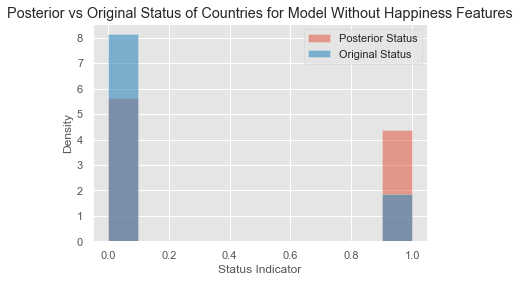

In [51]:
plt.hist(trace_without.posterior['status'].values.flatten(), density=True, alpha=0.5, label='Posterior Status') 
plt.hist(x=grouped['status indicator'], density=True, alpha=0.6, label='Original Status')

plt.xlabel('Status Indicator')
plt.ylabel('Density')
plt.title('Posterior vs Original Status of Countries for Model Without Happiness Features')
plt.legend(loc='upper right')